In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [ ]:
import random
import copy
 
def check_index(i, j):
  return 0 <= i < 5 and 0 <= j < 5  #смотрим не вылезли ли мы за поле
 
 
def add_ship(field, size_of_ship): #добавляем корабль
  versions = list()      #версии после того, как добавим корабль (все возможные исходы)   
  for i in range(len(field)):  
    for j in range(len(field) + 1 - size_of_ship):    #идем по полю
      flag = True  
      for k in range(size_of_ship):   
        if field[i][j + k] != 0:  #если занято, добавить не можем
          flag = False
      if flag:  #если свободно 
        versions.append(copy.deepcopy(field)) # добавляем корабль на поле
        for k1 in [-1, 0, 1]:  
          for k2 in ([-1] + list(range(size_of_ship + 1))):
            if k1 == 0 and k2 in list(range(size_of_ship)):    # бежим по соседним точкам корабля, добавляем корабль из 1 и даем рамку из -1
              versions[-1][i + k1][j + k2] = 1
            elif check_index(i + k1, j + k2):
              versions[-1][i + k1][j + k2] = -1
  if size_of_ship >= 2: # если не однопалубный то не перебирать версии, а если двух, то иметь возможность развернуть
    for i in range(len(field)):    #если идем по табличке 
      for j in range(len(field) + 1 - size_of_ship):  
        flag = True 
        for k in range(size_of_ship):  
          if field[j + k][i] != 0: #если занято
            flag = False
        if flag: #если свободно
          versions.append(copy.deepcopy(field))   # бежим по соседним точкам корабля, добавляем корабль из 1 и даем рамку из -1
          for k1 in [-1, 0, 1]:
            for k2 in ([-1] + list(range(size_of_ship + 1))):
              if k1 == 0 and k2 in list(range(size_of_ship)):
                versions[-1][j + k2][i + k1] = 1
              elif check_index(i + k1, j + k2):
                versions[-1][j + k2][i + k1] = -1
  if len(versions) == 0:  #если корабль не добавили, то просто ретернем пустой список
    return []
  return random.choice(versions) #возвращаем рандомную версию с кораблем
 
    

In [ ]:
#разворачиваем квадратную матрицу в вектор 
def to_linear(field):
  answer = []
  for i in range(len(field)):
    for j in range(len(field)):
      answer.append(int(field[i][j] == 1))
  return answer

#def check_pos(pos, pos_now):
  #if not (0 <= pos < 100):
    #return False
  #if abs(pos - pos_now) % 10 == 1 and   

#делаем симуляцию игры 5 на 5
class environment():
  def __init__(self):
    self.table = to_linear(add_ship([[0 for i in range(5)] for j in range(5)], random.choice([1, 2, 3, 4]))) #заполним наше поле 1337 - 1337 означает, что клетка не покрыта (способ сомнительный)
    self.dead = 0
  
   
  def  give_me_state(self):
    tmp = copy.deepcopy(self.table) #делаем резервную таблицу
    for i in range(len(tmp)):
      if tmp[i] == 2: #если попали
         tmp[i] = 1 
      elif tmp[i] == 1: #если промазали
         tmp[i] = 0  
    return tmp
     #torch.tensor(tmp, dtype = torch.float32)  
            
  def check_ship(self, pos_now, pos_old):
    flag = True
    if self.table[pos_now] == 1:
      return False
    if self.table[pos_now] == -1 or self.table[pos_now] == 0:
      return True
    tmp = [-1, 1, -5, 5]
    for shift in tmp:
      pos = shift + pos_now
      if pos != pos_old and 0 <= pos < 25 and (abs(shift) != 1 or  pos // 5 == (pos - shift) // 5):
        flag = flag and self.check_ship(pos, pos_now)
    return flag

  def dead_ship(self, pos_now, pos_old):
      tmp = [-1, 1, -5, 5]
      if self.table[pos_now] != 2:
        return
      for shift in tmp:
        pos = shift + pos_now
        if pos != pos_old and 0 <= pos < 25 and (abs(shift) != 1 or  pos // 5 == (pos - shift) // 5):
          self.dead_ship(pos, pos_now)
      self.table[pos_now] = -1    
      #for l in [-1, 0, 1]:
        #for r in [-10, 0, 10]:
          #pos = pos_now + l + r
          #if check_pos(pos, pos_now):
            #self.table[pos] = -1
   
  def check_dead(self, action):
    if self.check_ship(action, -1):
      self.dead += 1
      self.dead_ship(action, -1)


  def after_action(self, action):  
    global old_action
    if self.table[action] == 1: # кусок корабля
      self.table[action] = 2
      rew = 2
      self.check_dead(action)
    elif self.table[action] == 0:
      self.table[action] = -1
      rew = 0 #пусто
      #print('action', action)
      #if len(old_action) > 1:
        #print('old_action', old_action[-2])
      if ((len(old_action) > 1) and (action // 5 == old_action[-2] // 5) and abs(old_action[-2] - action) == 1):
        rew = 1
      if len(old_action) > 1 and abs(action - old_action[-2]) == 5:
        rew = 1
    else:
      rew = -2
    finish = (self.dead == 1) #(придумать как показать, что все корабли убиты и игра закончена)
    return  self.give_me_state(), rew, finish  
      
      # награда, либо 1 (если попали), либо 0 (если не попали), если какой-то корабль уже бвл убит, а мы попали в клетку рядом с этим
      #кораблем (или если мы уже попали в клетку с 0 или 1 ?), то даем -1 
      #так же вернем следующее сосотояние(сделаем ход в табличке) и метку того, закончилась игра или нет 




In [ ]:
def print_table(state):
  global count_action
  global size_table
  counter = 1
  for i in range(count_action):
    if counter < size_table:
      print(state[i], end = ' ')
      counter += 1
    else:
      print(state[i])
      counter = 1
  return    


In [ ]:
count_action = 25
size_table = 5

In [ ]:
play = environment()

Сосдаем сетку на 4 слоя, 25 - это размер нашего поля в длину (5x5) (за функцию активации используем релу так как нужно быстро и эффективно (правило блльшого пальца))

In [ ]:
#сетка выдаст мн-во Q(s,ai)
SimpleCnn = nn.Sequential()
SimpleCnn.add_module("layer1", nn.Linear(25, 128))
SimpleCnn.add_module("activation1",nn.ReLU())
SimpleCnn.add_module("layer2", nn.Linear(128, 256))
SimpleCnn.add_module("activation2",nn.ReLU())
SimpleCnn.add_module("layer3", nn.Linear(256, 128))
SimpleCnn.add_module("activation3",nn.ReLU())
SimpleCnn.add_module("layer4", nn.Linear(128, 25))
#SimpleCnn.add_module("activation3",nn.Softmax(dim=0))


#SimpleCnn.add(Conv1D(input_shape, 32, padding = 'valid', activation = 'relu'))
#SimpleCnn.add(Conv1D(32, 32, padding = 'valid', activation = 'softmax'))
#SimpleCnn.add(Conv1D(32, 100, padding = 'valid', activation = 'sigmoid'))

In [ ]:
count_action = 25

Нужно найти аргументы, для которых наша функция будет принимать минимальные значения, нужно обновлять параметры, для этого нам потребуется Градиентный спуск.
Воспользуемся градиентной оптимизацией, возьмем Adam, который является комбинацией двух методо: RMSprob и momentum. Возьмем lr = 1e-4 (Константа имени карапатова это lr = 3e-4). 
Было опробовано несколько констант, но в итоге по наблюдениям быстрее всего сходится с 1e-10 ( попробовать еще раз).

In [ ]:
opt = torch.optim.Adam(SimpleCnn.parameters(), lr = 1e-4)
eps = 0.5

Наша главная цель обучить модель добивать корабль, поэтому для более быстрого обучения поможем нашей сетке, если она промазала или попала в запрещенную клетку (где уже стоит корабль), то включается рандомный ход. Если же было произведено попадание (не важно с помощью рандома или нет), то начинается добивания корабля с помощью выбора наилучшего, а не рандомного действия.

In [ ]:
old_action = []
def find_best_actions(state, eps, r):
  global arr
  global old_action
  tmp = -1
  state = torch.tensor(state, dtype = torch.float32)
  if (r == -2 or r == 0) and len(arr) > 0:
    action = np.random.choice(arr)
    for i in range(len(arr)):
      if (arr[i] == action):
        tmp = i
    arr = np.delete(arr, np.array([tmp]))
  else: 
    action = np.argmax(SimpleCnn(state).detach().numpy()) #предположительно отправляем это в нашу сетку, выбираем max(Q(s, ai)) и стреляем )
    for i in range(len(arr)):
      if (arr[i] == action):
        tmp = i
    if tmp != -1:
      arr = np.delete(arr, np.array([tmp]))
  old_action.append(int(action))    
  return int(action)                            #т е мы выбрали лучшее действие , индекс   

Для обучения в работе используется Deep Q-learning.

In [ ]:
def to_one_hot(y_tensor, n_dims = None):
  y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
  n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
  y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
  return y_one_hot

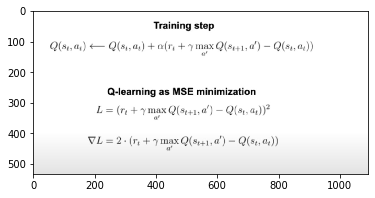

In [1]:
import imageio
img = imageio.imread('./loss.jpg')
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

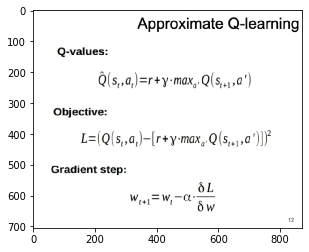

In [2]:
import imageio
img = imageio.imread('./train.jpg')
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
def loss(states, actions, rewards, next_states, finish, gamma = 0.5):
  states = torch.tensor(states, dtype = torch.float32)
  rewards = torch.tensor(rewards, dtype = torch.float32)
  actions = torch.tensor(actions, dtype = torch.int32)
  next_states = torch.tensor(next_states, dtype = torch.float32)  # набор sars'
  finish = torch.tensor(finish, dtype = torch.float32) #флаг, что наша сессия не завершилась в том или ином варинте, т е завершилась наша игра или нет
  pred_Q = SimpleCnn(states) #сетка вернет мн-во Q(s_{t},a_{i}))
  pred_Q_action = torch.sum(pred_Q * to_one_hot(actions, count_action)) #Q(s_{t},a_{t} наилучшее действие для состояния t
  #print(pred_Q_action)
  pred_next_Q = SimpleCnn(next_states) # сетка вернет Q(s_{t+1},a')
  #print(pred_next_Q)
  with torch.no_grad():
    next_state_action = torch.max(pred_next_Q, dim = 1)[0] #максимально полезная функция для t+1-го состояния max(Q(s_{t+1},a'))
  target_Q_actions = rewards + gamma * next_state_action # r_{t} + gamma * max(Q(s_{t+1},a'))
  target_Q_actions = finish * rewards + (1 - finish) * target_Q_actions #эта формула будет полезнf в самом конце, когда s' перестанет существовать 
  loss = torch.mean((pred_Q_action - target_Q_actions.detach())**2) #Q-learning mse minimization
  return loss

In [ ]:
def learning():
  global play, rewards, arr #обращение к глобальной переменной
  r = 0
  rew_check = [0, 0, 0, 0, 0]
  sum_reward = 0
  state = play.give_me_state() # состояние
  for tmp in range(1000):
    action = find_best_actions(state, r)
    next_state, r, finish = play.after_action(action) # что будет при действии a
    opt.zero_grad()
    loss([state], [action], [r], [next_state], [finish]).backward() #вычисляет сумму градиентов заданных тензоров
    opt.step()
    sum_reward += r
    #print(print_table(next_state))
    #print('action',action)
    state = next_state
    rew_check[r + 2] += 1 
    if finish:
      #print(next_state)
      arr = np.arange(25)
      print('штраф за попадание в запрещенную клетку (reward = -2)', rew_check[0])
      print('промах (reward = 0)', rew_check[2])
      print('поощрение за попытку добить корабль (reward = 1)', rew_check[3])
      print('ранение (reward = 2)', rew_check[4])
      rew_check = []
      rewards = []
      play = environment()
      break
  return sum_reward     

In [ ]:
rewards = []
arr = np.arange(25)


In [ ]:
for i in range(1000000):
  session_rewards = [learning(eps = eps, train = True)]
  if (i % 10000 == 0):
    torch.save(SimpleCnn, "model" + str(i // 10000) + ".zip")
  print('epoh:', i, 'reward:', session_rewards[0])

  rewards.append(session_rewards[0])


Выходные данные были обрезаны до нескольких последних строк (5000).
штраф за попадание в запрещенную клетку (reward = -2) 0
промах (reward = 0) 7
поощрение за попытку добить корабль (reward = 1) 1
ранение (reward = 2) 2
epoh: 293357 reward: 5
штраф за попадание в запрещенную клетку (reward = -2) 0
промах (reward = 0) 3
поощрение за попытку добить корабль (reward = 1) 0
ранение (reward = 2) 4
epoh: 293358 reward: 8
штраф за попадание в запрещенную клетку (reward = -2) 0
промах (reward = 0) 7
поощрение за попытку добить корабль (reward = 1) 1
ранение (reward = 2) 2
epoh: 293359 reward: 5
штраф за попадание в запрещенную клетку (reward = -2) 0
промах (reward = 0) 4
поощрение за попытку добить корабль (reward = 1) 0
ранение (reward = 2) 2
epoh: 293360 reward: 4
штраф за попадание в запрещенную клетку (reward = -2) 0
промах (reward = 0) 9
поощрение за попытку добить корабль (reward = 1) 0
ранение (reward = 2) 3
epoh: 293361 reward: 6
штраф за попадание в запрещенную клетку (reward = -2) 1
п

In [ ]:
def my_print(table):
  for i in range(5):
    for j in range(5):
      print(table[i * 5 + j], end=' ')
    print()

In [ ]:
class environment1():
  def __init__(self):
    self.table = to_linear(add_ship(add_ship([[0 for i in range(5)] for j in range(5)], random.choice([1, 2, 3, 4])), random.choice([1, 2, 3, 4]))) #заполним наше поле 1337 - 1337 означает, что клетка не покрыта (способ сомнительный)
    self.dead = 0
  
  def to_numb(x):
    x = x.lower()
    if x[0] == "a":
      return 1
    if x[0] == "b":
      return 2 
    if x[0] == "c":
      return 3
    if x[0] == "d":
      return 4
    if x[0] == "e":
      return 5 
    if x[0] == "f":
      return 6
    if x[0] == "g":
      return 7
    if x[0] == "h":
      return 8 
    if x[0] == "i":
      return 9
    if x[0] == "j":
      return 10
    return 0
   
  def  give_me_state(self):
    tmp = copy.deepcopy(self.table) 
    for i in range(len(tmp)):
      if tmp[i] == 2:
         tmp[i] = 1
      elif tmp[i] == 1:
         tmp[i] = 0  
    return tmp
     #torch.tensor(tmp, dtype = torch.float32)  
            
  def check_ship(self, pos_now, pos_old):
    flag = True
    if self.table[pos_now] == 1:
      return False
    if self.table[pos_now] == -1 or self.table[pos_now] == 0:
      return True
    tmp = [-1, 1, -5, 5]
    for shift in tmp:
      pos = shift + pos_now
      if pos != pos_old and 0 <= pos < 25 and (abs(shift) != 1 or  pos // 5 == (pos - shift) // 5):
        flag = flag and self.check_ship(pos, pos_now)
    return flag

  def dead_ship(self, pos_now, pos_old):
      tmp = [-1, 1, -5, 5]
      if self.table[pos_now] != 2:
        return
      for shift in tmp:
        pos = shift + pos_now
        if pos != pos_old and 0 <= pos < 25 and (abs(shift) != 1 or  pos // 5 == (pos - shift) // 5):
          self.dead_ship(pos, pos_now)
      self.table[pos_now] = -1    
      #for l in [-1, 0, 1]:
        #for r in [-10, 0, 10]:
          #pos = pos_now + l + r
          #if check_pos(pos, pos_now):
            #self.table[pos] = -1
   
  def check_dead(self, action):
    if self.check_ship(action, -1):
      self.dead += 1
      self.dead_ship(action, -1)


  def after_action(self, action):  
    global old_action
    if self.table[action] == 1: # кусок корабля
      self.table[action] = 2
      rew = 2
      self.check_dead(action)
    elif self.table[action] == 0:
      self.table[action] = -1
      rew = 0 #пусто
      #print('action', action)
      #if len(old_action) > 1:
        #print('old_action', old_action[-2])
      if ((len(old_action) > 1) and (action // 5 == old_action[-2] // 5) and abs(old_action[-2] - action) == 1):
        rew = 1
      if len(old_action) > 1 and abs(action - old_action[-2]) == 5:
        rew = 1
    else:
      rew = -2
    finish = (self.dead == 2) #(придумать как показать, что все корабли убиты и игра закончена)
    return  self.give_me_state(), rew, finish  
      
      # награда, либо 1 (если попали), либо 0 (если не попали), если какой-то корабль уже бвл убит, а мы попали в клетку рядом с этим
      #кораблем (или если мы уже попали в клетку с 0 или 1 ?), то даем -1 
      #так же вернем следующее сосотояние(сделаем ход в табличке) и метку того, закончилась игра или нет 




In [ ]:
game = environment1()

finish = False
r = 0
my_print(game.table)
print()
arr = np.arange(25)
while not finish:
  state = game.give_me_state()
  action = find_best_actions(state, 0, r)
  next_state, r, finish = game.after_action(action)
  my_print(next_state)
  print()


In [ ]:
def to_char(x):
  if x == 2 or x == 3: # 2 - ранен, 3 - откинулся совсем
    return '!'
  if x == -1:
    return '*'
  return '0'

class smart_table():
  def __init__(self):
    self.table = self.generation_table()
    self.dead = 0
    self.for_nn = False

  def __str__(self): #! - есть пробитие, * - мимо, 0 - окутано неизвестностью
    tmp = ""
    for i in range(len(self.table)):
      for j in range(len(self.table)):
        tmp += to_char(self.table[i][j]) + ' '
      tmp += '\n'
    return tmp
             
  def print_for_player(self): #m - пустая, h - часть корабля
    tmp = ""
    for i in range(len(self.table)):
      for j in range(len(self.table)):
        tmp += self.table[i][j] * 'h' + (1 - self.table[i][j]) * 'm' + ' '
      tmp += '\n'
    print(tmp)
    

  def try_generation_table(self):
    global size_table
    tmp = [[0 for i in range(size_table)] for j in range(size_table)]
    size_ship = [3, 2, 1, 1, 1]
    for ship in size_ship:
      tmp = add_ship(tmp, ship)
    return tmp
  
  def generation_table(self): 
    tmp = self.try_generation_table() 
    while len(tmp) == 0:
      tmp = self.try_generation_table()
    for i in range(len(tmp)):
      for j in range(len(tmp[i])):
        tmp[i][j] = int(tmp[i][j] == 1) # зачищаем поле от ненужного мусора для генерации, необходимо, чтобы поле дальше было готовым для игры
    return tmp

  def table_for_nn(self): # версия для нашей нейросеточки)
    tmp = []
    for i in range(len(self.table)):
      for j in range(len(self.table)):
        if self.table[i][j] == 2: # для сетки видна полученная награда в 1
          tmp.append(1)
        elif self.table[i][j] == 3 or self.table[i][j] == -1: # для сетки виден бан в -1
          tmp.append(-1)
        else: # сетка подумает, что сюда можно стрелять (пушка заряжена, но не стреляет)
          tmp.append(0)
    return torch.tensor(tmp, dtype=torch.float32)
  
  def check_end(self):
    return self.dead == 5

  def check_ship(self, i, j, i_old, j_old):
    global size_table
    if i < 0 or j < 0 or i >= size_table or j >= size_table:
      return True
    if self.table[i][j] == 1:
      return False
    flag = True
    if self.table[i][j] == 2:
      for i_shift, j_shift in [(-1, 0), (1, 0), (0, -1), (0, 1)]: # все возможные сдвиги по горизонтали и по вертикали
        if (i + i_shift, j + j_shift) != (i_old, j_old): # не хотим проверять клетку, откуда пришли, а то рекурсия замкнётся :(
          flag = flag and self.check_ship(i + i_shift, j + j_shift, i, j) # смотрим есть ли нестрелянные палубы у корабля
    return flag

  def change_ship(self, i, j): # метим, что весь корабль уничтожен
    global size_table
    self.table[i][j] = 3 
    for i_shift, j_shift in [(-1, -1), (0, -1), (1, -1), (-1, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]: # смотрим соседние клетки
      if i + i_shift >= 0 and j + j_shift >= 0 and i + i_shift < size_table and j + j_shift < size_table: # проверяем сущестование клетки
        if self.table[i + i_shift][j + j_shift] == 2:
          self.change_ship(i + i_shift, j + j_shift)
        else:
          if self.table[i + i_shift][j + j_shift] != 3:
             self.table[i + i_shift][j + j_shift] = -1 # -1 - это промах, если кто-то вдруг забыл :)
  
  def do_action(self, i, j):
    if self.table[i][j] == 1:
      self.table[i][j] = 2
      self.for_nn = True
      if self.check_ship(i, j, -1, -1):
        self.dead += 1
        self.for_nn = False 
        self.change_ship(i, j)
      return True
    elif self.table[i][j] == 0:
      self.table[i][j] = -1
    return False

  def action_list(self):
    global size_table
    tmp = []
    for i in range(size_table):
      for j in range(size_table):
        if self.table[i][j] == 1 or self.table[i][j] == 0:
          tmp.append([i, j])
    return tmp

In [ ]:
# 0 - первый игрок, 1 - второй игрок
class game_play():
  def __init__(self, human):
    self.tables = []
    self.player_now = 0
    self.human = human
    self.create_table()
  def create_table(self):
    for i in range(0, 2):
      self.tables.append(smart_table())
      if i == self.human:
        print('Напишите YES, если вам понравится сгенерированное поле и NO иначе')
        self.tables[i].print_for_player()
        tmp = input()
        while tmp != 'YES':
          self.tables[i] = smart_table()
          self.tables[i].print_for_player()
          tmp = input()
  def play_until_finish(self):
    global size_table
    old = 0
    while not self.tables[0].check_end() and not self.tables[1].check_end():
      if self.player_now == self.human:
        i, j = self.get_human_action()
      else:
        if self.tables[1 - self.player_now].for_nn:
          action = np.argmax(SimpleCnn(self.tables[1 - self.player_now].table_for_nn()).detach().numpy())
          i, j = map(int, [action / size_table, action % size_table])
        else:
          i, j = random.choice(self.tables[1 - self.player_now].action_list())
      old = self.player_now
      if  not self.tables[1 - self.player_now].do_action(i, j):
        self.player_now = 1 - self.player_now
      if (old != self.human):
        print("Ход противника")
        print(self.tables[self.human])
        print()
    if self.tables[0].check_end():
      self.print_winner(1)
    else:
      self.print_winner(0)
  def get_human_action(self):
    #print(self.tables[1 - self.player_now])
    #print("Выбирай свой ход парой индексов")
    #print()
    i, j = map(int, input().split())
    return i, j
  def print_winner(self, winner):
    if winner == self.human:
      print("С победой, человече!")
    else:
      print("Ну F, Вас переиграла машина. Ха-ха-ха.\n\t\t\t\t Би-Бип")